In [1]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GroupKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from equationmodel_ann import ann_mlp_regression, prediction_rmse_error, ann_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraphWithGroupingFrequency,\
                makeXforGraph, inverseScale, samplingData, normalizeData,train_2d_graph, train_3d_graph

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)
pd.options.display.float_format = "{:.2f}".format

In [2]:
%autoreload

paju_wt_fileList = {'../data/PLdata_paju_wt_400.csv':[('season', 0), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('season', 0), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('season', 0), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_sp_fileList = {'../data/PLdata_paju_sp_400.csv':[('season', 0.5), ('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_paju_sp_1399.csv':[('season', 0.5), ('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_paju_sp_2249.csv':[('season', 0.5), ('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_sm_fileList = {'../data/PLdata_paju_sm_400.csv':[('season', 1.0), ('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_1399.csv':[('season', 1.0), ('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_sm_2249.csv':[('season', 1.0), ('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addPajuWt = ADD_data_loader(paju_wt_fileList)
print("Paju winter data:",addPajuWt.shape)
print("")
addPajuSp = ADD_data_loader(paju_sp_fileList)
print("Paju spring data:",addPajuSp.shape)
print("")
addPajuSm = ADD_data_loader(paju_sm_fileList)
print("Paju summer data:",addPajuSm.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addPajuWt, addPajuSp, addPajuSm])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

ADD data preprocessing
../data/PLdata_paju_wt_400.csv: distance filtering(before):(110440, 4)
../data/PLdata_paju_wt_400.csv: distance filtering(after):(22532, 4)
../data/PLdata_paju_wt_2249.csv: distance filtering(before):(110246, 4)
../data/PLdata_paju_wt_2249.csv: distance filtering(after):(22505, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(before):(110358, 4)
../data/PLdata_paju_wt_1399.csv: distance filtering(after):(22518, 4)
          type  distance  pathloss  heightTM  season  frequency  heightTB  heightB  heightM
type 1719    m      1.00    100.29      0.02       0        400        30       15        2
     1720    m      1.00    124.49      0.04       0        400        30       15        2
     1721    m      1.00     92.21      0.03       0        400        30       15        2
     1722    m      1.00     93.33      0.01       0        400        30       15        2
     1723    m      1.00    100.66      0.02       0        400        30       15        2
C

data distribution(before)
       logDistance  logFrequency  logExtendedHeightTratio    season  pathloss
count    123134.00     123134.00                123134.00 123134.00 123134.00
mean          0.39          3.04                    -0.43      0.54    127.74
std           0.16          0.31                     0.27      0.45     14.12
min           0.00          2.60                    -0.95      0.00     85.47
25%           0.28          2.60                    -0.65      0.00    117.05
50%           0.41          3.15                    -0.42      0.50    128.39
75%           0.52          3.35                    -0.24      1.00    138.74
max           0.60          3.35                     0.35      1.00    171.41
sampling shape(before):(123134, 5)
sampling shape(after):(12313, 5)
data distribution(after)
       logDistance  logFrequency  logExtendedHeightTratio   season  pathloss
count     12313.00      12313.00                 12313.00 12313.00  12313.00
mean          0.45       

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2880: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


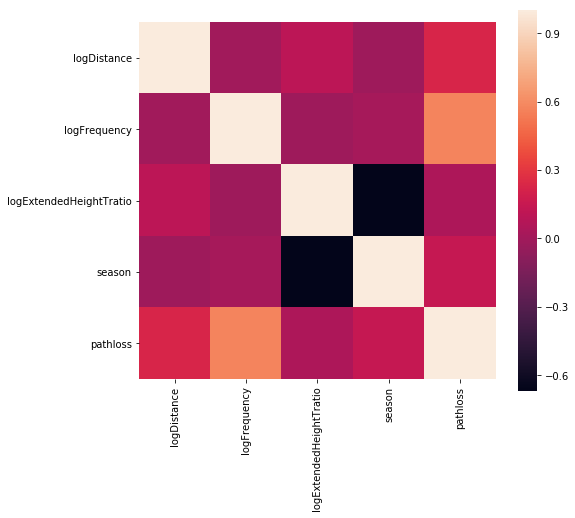

In [3]:
%autoreload

targetCols = ['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season', 'pathloss']
xCols = ['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season',]
yCols = 'pathloss'

samplingRatio = 0.1
addData = samplingData(addData[targetCols], samplingRatio, 'logDistance')
# addDataSample.sort_values(by=['logDistance'])

sc = 'manual'

addDataNorm, normalizer = normalizeData(addData[targetCols], addData[yCols], scaler = sc)

print("\nADD data description")
print(addDataNorm.describe()['pathloss'])
print("\nCovariance Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
print(addDataNorm.cov()['pathloss'])

print("\nCorrelation Matrix - ADD data[Target Columns]")
print("Target Columns:", targetCols)
corrMat = addDataNorm.corr()
print(corrMat)
f, ax = plt.subplots(figsize=(8,7))
sns.heatmap(corrMat, square=True)

X = np.array(addDataNorm[xCols])
Xorigin = np.array(addData[xCols]) 
Y = np.array(addData[yCols])

In [4]:
print("ANN-MLP Regression train/test Error")
kf = KFold(n_splits=5, shuffle=True)

modelList = []
dataSet = []
i = 1
trainErrSum, testErrSum = 0, 0
model = ann_mlp_regression((60,), activation='logistic', optimizer='lbfgs')

for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]    

    model.fit(X_train, y_train.flatten())
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))
    
    trainErrSum += trainError
    testErrSum += testError
    print("#"+str(i)+" Error(RMSE)-train:{} / test:{}".format(trainError,testError)) 
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    filename = "model/ann_"+sc+".sav"
    pickle.dump(model, open(filename, 'wb'))

    i+=1
i-=1
avgTrainError, avgTestError = trainErrSum/i, testErrSum/i 
print("\nAverage train error:{:.2f} | Average test error:{:.2f}".format(avgTrainError, avgTestError))

ANN-MLP Regression train/test Error
#1 Error(RMSE)-train:9.171645100049734 / test:9.526102749280508
#2 Error(RMSE)-train:8.91987097749871 / test:9.604812376126837
#3 Error(RMSE)-train:9.240926522623374 / test:9.382216163941255
#4 Error(RMSE)-train:9.198778760920757 / test:9.333580604922204
#5 Error(RMSE)-train:9.20374062030435 / test:9.168274728701286

Average train error:9.15 | Average test error:9.40


In [5]:
X_testSet, Y_testSet = np.zeros((X.shape)), np.zeros((1,))
for X_train, y_train, X_test,y_test, trainError, testError in dataSet:
    X_testSet = np.concatenate((X_testSet, X_test), axis=0)
    Y_testSet = np.concatenate((Y_testSet, y_test), axis=0)

X_testSet = np.delete(X_testSet, 0, 0)
Y_testSet = np.delete(Y_testSet, 0, 0)

Group-  0.26Ghz Data shape:(4064, 5)
Group-  0.31Ghz Data shape:(4104, 5)
Group-  0.34Ghz Data shape:(4145, 5)


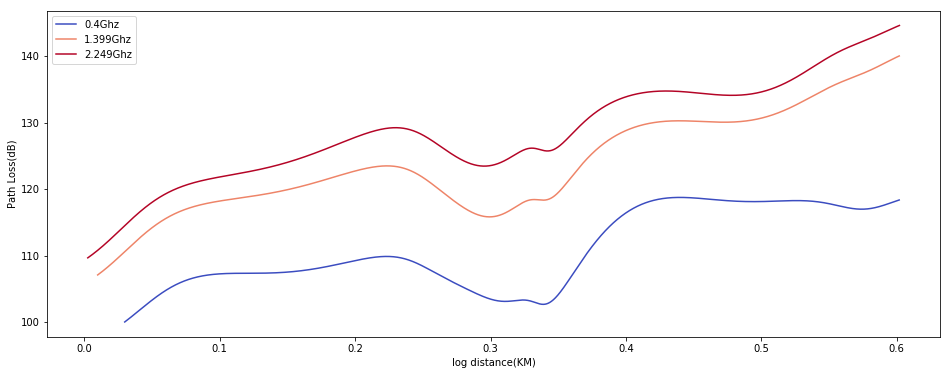

In [6]:
%autoreload
model = pickle.load(open("model/ann_"+sc+".sav", 'rb'))

data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logExtendedHeightTratio', 'season'])

graphX = data[0]
graphY = data[1]
train_2d_graph(model, normalizer, graphX, graphY, 'logDistance', "log distance(KM)")

Group-  0.26Ghz Data shape:(4064, 5)
Group-  0.31Ghz Data shape:(4104, 5)
Group-  0.34Ghz Data shape:(4145, 5)


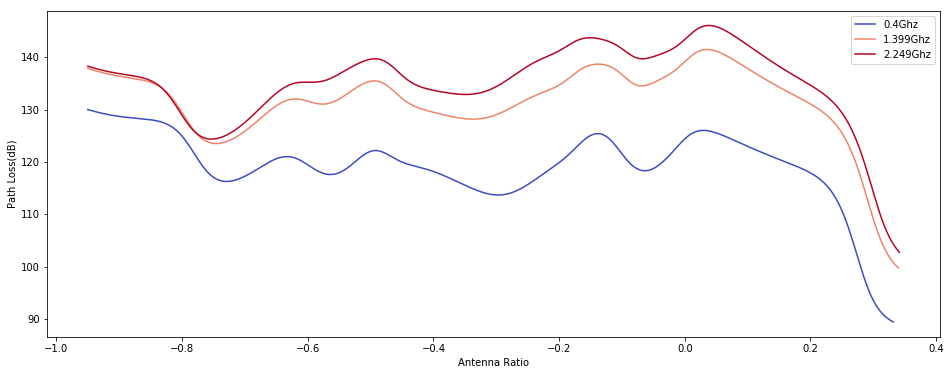

In [7]:
%autoreload
model = pickle.load(open("model/ann_"+sc+".sav", 'rb'))

data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logDistance', 'season'])

graphX = data[0]
graphY = data[1]
train_2d_graph(model, normalizer, graphX, graphY, 'logExtendedHeightTratio', "Antenna Ratio")

Group-  0.26Ghz Data shape:(4064, 5)
Group-  0.31Ghz Data shape:(4104, 5)
Group-  0.34Ghz Data shape:(4145, 5)


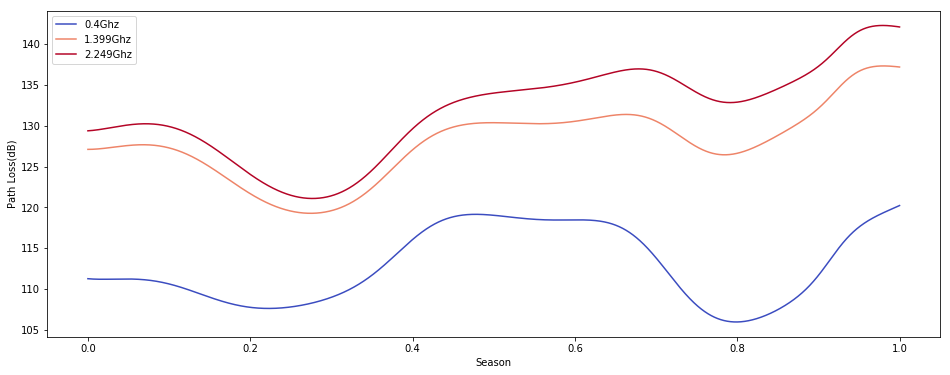

In [8]:
%autoreload
model = pickle.load(open("model/ann_"+sc+".sav", 'rb'))

data = makeXforGraphWithGroupingFrequency(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), ['logDistance', 'logExtendedHeightTratio'])

graphX = data[0]
graphY = data[1]
train_2d_graph(model, normalizer, graphX, graphY, 'season', "Season")

3D graph for log distance and log frequency - trainset #1
Index(['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logExtendedHeightTratio   season
count     10000.00      10000.00                 10000.00 10000.00
mean          0.30          0.30                    -0.42     0.54
std           0.17          0.02                     0.00     0.00
min           0.00          0.26                    -0.42     0.54
25%           0.15          0.28                    -0.42     0.54
50%           0.30          0.30                    -0.42     0.54
75%           0.45          0.32                    -0.42     0.54
max           0.60          0.34                    -0.42     0.54


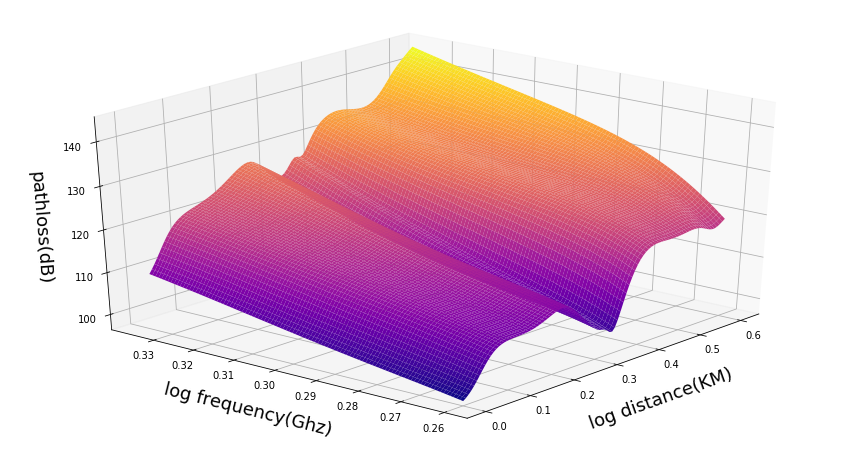

In [9]:
%autoreload
i = 1
model = pickle.load(open("model/ann_"+sc+".sav", 'rb'))

print("3D graph for log distance and log frequency - trainset #{}".format(i))
targetCols = ['logDistance', 'logFrequency']
xLabel,yLabel,zLabel = "log distance(KM)","log frequency(Ghz)","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), targetCols)

graphX = data[0]
graphY = data[1]
train_3d_graph(model, graphX, graphY, targetCols, xLabel, yLabel, zLabel)

3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logExtendedHeightTratio   season
count     10000.00      10000.00                 10000.00 10000.00
mean          0.30          0.30                    -0.30     0.54
std           0.17          0.00                     0.38     0.00
min           0.00          0.30                    -0.95     0.54
25%           0.15          0.30                    -0.63     0.54
50%           0.30          0.30                    -0.30     0.54
75%           0.45          0.30                     0.02     0.54
max           0.60          0.30                     0.34     0.54


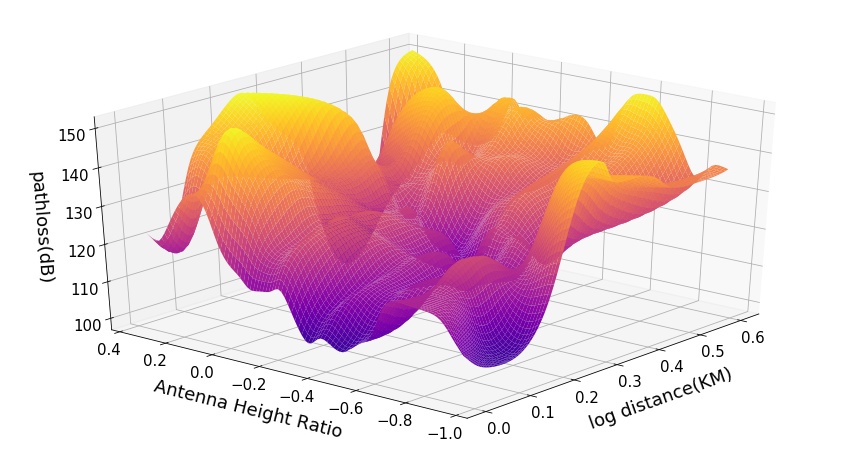

In [10]:
%autoreload
i = 1
model = pickle.load(open("model/ann_"+sc+".sav", 'rb'))

print("3D graph for log distance and log antenna height B+TB/M+TM ratio - trainset #{}".format(i))
xLabel,yLabel,zLabel = "log distance(KM)","Antenna Height Ratio","pathloss(dB)"
varX = ['logDistance', 'logExtendedHeightTratio']
data = makeXforGraph(pd.DataFrame(X, columns=xCols),
                     pd.DataFrame(Y, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(model, graphX, graphY, varX, xLabel, yLabel, zLabel)


3D graph for log distance and log antenna height B ratio - trainset #1
Index(['logDistance', 'logFrequency', 'logExtendedHeightTratio', 'season'], dtype='object')
input data/feature distribution:
        logDistance  logFrequency  logExtendedHeightTratio   season
count     10000.00      10000.00                 10000.00 10000.00
mean          0.30          0.15                    -0.21     0.50
std           0.18          0.00                     0.00     0.29
min           0.00          0.15                    -0.21     0.00
25%           0.15          0.15                    -0.21     0.25
50%           0.30          0.15                    -0.21     0.50
75%           0.45          0.15                    -0.21     0.75
max           0.60          0.15                    -0.21     1.00


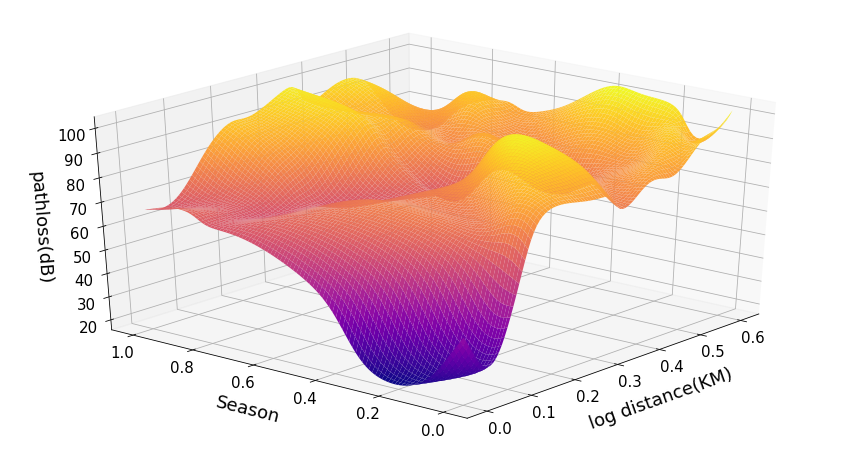

In [11]:
%autoreload
i = 1
model = pickle.load(open("model/ann_"+sc+".sav", 'rb'))

print("3D graph for log distance and log antenna height B ratio - trainset #{}".format(i))
varX = ['logDistance', 'season', ]
xLabel,yLabel,zLabel = "log distance(KM)","Season","pathloss(dB)"
data = makeXforGraph(pd.DataFrame(X_testSet, columns=xCols),
                     pd.DataFrame(Y_testSet, columns=['pathloss']), varX)

graphX = data[0]
graphY = data[1]
train_3d_graph(model, graphX, graphY, varX, xLabel, yLabel, zLabel)

In [12]:
%autoreload

#logDistance  logFrequency  logHeightB  logHeightM  logExtendedHeightTratio  logHeightTratio  logAntennaMulLogDistance
i = 1
coefSum, interceptSum = np.array([0]*7), 0

linearModel = Ridge(alpha=0.0001)
ANNmodel = pickle.load(open("model/ann_"+sc+".sav", 'rb'))

for X_train, y_train, X_test, y_test, trainError, testError in dataSet:
    print("-"*100)
#     X_train = scaler.inverse_transform(X_train)
#     X_test = scaler.inverse_transform(X_test)
    print("Equation Derivation for trainset #{}".format(i))

    ANNPred = ANNmodel.predict(X_train)
    
    linearModel.fit(X_train, ANNPred)     
    linearPredTrain = linearModel.predict(X_train)
    linearPredTest = linearModel.predict(X_test)
    
    RMSE_LIN_TRAIN = np.sqrt(mean_squared_error(linearPredTrain, y_train))
    RMSE_LIN_TEST = np.sqrt(mean_squared_error(linearPredTest, y_test))
    RMSE_LIN_ANN = np.sqrt(mean_squared_error(ANNPred, linearPredTrain))

    print("ANN-Error(RMSE)-"+str(i)+"-train:{:6.2f}/test:{:6.2f}".format(trainError, testError))
    print("Linear-Error(RMSE)-"+str(i)+"-train:{:6.2f}/test:{:6.2f}".format(RMSE_LIN_TRAIN,RMSE_LIN_TEST))
    print("ANN-Linear-Error(RMSE):", RMSE_LIN_ANN)    

    print("\nObjective Function")
    print("L_pathloss = {:6.2f}log_d + {:6.2f}log_f + {:6.2f}log_(h_tb + h_b/h_tm + h_m) + {:6.2f}s + {:6.2f}"\
      .format(linearModel.coef_[0],linearModel.coef_[1]
              *0.1,linearModel.coef_[2],\
              linearModel.coef_[3],linearModel.intercept_)) 

----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #1
ANN-Error(RMSE)-1-train:  9.17/test:  9.53
Linear-Error(RMSE)-1-train: 10.44/test: 10.64
ANN-Linear-Error(RMSE): 5.024690553734333

Objective Function
L_pathloss =  24.40log_d +  25.01log_f +  11.30log_(h_tb + h_b/h_tm + h_m) +   8.88s +  41.68
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #1
ANN-Error(RMSE)-1-train:  8.92/test:  9.60
Linear-Error(RMSE)-1-train: 10.45/test: 10.59
ANN-Linear-Error(RMSE): 5.055109029379139

Objective Function
L_pathloss =  23.98log_d +  24.98log_f +  11.02log_(h_tb + h_b/h_tm + h_m) +   8.55s +  42.04
----------------------------------------------------------------------------------------------------
Equation Derivation for trainset #1
ANN-Error(RMSE)-1-train:  9.24/test:  9.38
Linear-Error(RMSE)-1-train: 10.48/test: 10.46
ANN-Linear